In [44]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Your selected columns
selected_num_columns = ['LotFrontage', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'SalePrice']
categorical_columns_filtered = ['Street', 'LandContour', 'LandSlope', 'Utilities', 'Neighborhood',
                                  'Condition1', 'Condition2', 'HouseStyle', 'BldgType', 'OverallQual',
                                  'OverallCond', 'RoofStyle', 'Exterior1st', 'ExterCond', 'BsmtCond',
                                  'BsmtFinType1', 'CentralAir', 'Heating', 'KitchenQual',
                                  'TotRmsAbvGrd', 'GarageType', 'GarageCond', 'PavedDrive',
                                  'SaleType', 'SaleCondition', 'Fireplaces', 'GarageCars']

categorical_columns_filtered = [ 'LandSlope',  'Neighborhood',
                                  'Condition1',  'HouseStyle', 'BldgType', 'OverallQual',
                                  'OverallCond', 'RoofStyle', 'Exterior1st', 'ExterCond', 'BsmtCond',
                                  'BsmtFinType1', 'KitchenQual',
                                  'TotRmsAbvGrd', 'GarageType',  'PavedDrive',
                                  'SaleType', 'SaleCondition', 'Fireplaces', 'GarageCars']

In [3]:
train_set = pd.read_csv('../data/train.csv')
test_set = pd.read_csv('../data/test.csv')

In [4]:
for column in categorical_columns_filtered[3:]:
    print(train_set[column].value_counts())
    

HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64
BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64
OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64
OverallCond
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: count, dtype: int64
RoofStyle
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: count, dtype: int64
Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64
ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: int6

In [6]:
# Define the target and features
# SalePrice is the target, so exclude it from features.
numeric_features = [col for col in selected_num_columns if col != 'SalePrice']
X = train_set[[col for col in selected_num_columns if col != 'SalePrice'] + categorical_columns_filtered]
y = train_set['SalePrice']

In [7]:



numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_columns_filtered)
    ]
)


In [8]:
# Create a pipeline with the preprocessor and the Gradient Boosting Regressor
gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gbr', GradientBoostingRegressor(random_state=42))
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
param_grid = {
    'gbr__n_estimators': [100, 200, 300],
    'gbr__learning_rate': [0.01, 0.05, 0.1],
    'gbr__max_depth': [3, 5, 7]
}

In [31]:
grid_search = GridSearchCV(
    gbr_pipeline,
    param_grid,
    cv=5,
    scoring=['neg_mean_squared_error', 'r2'], 
    refit='neg_mean_squared_error',  
    n_jobs=-1
)




In [32]:
print(gbr_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'gbr', 'preprocessor__force_int_remainder_cols', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__keep_empty_features', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imput

In [34]:
# Fit grid search on the training data
grid_search.fit(X_train, y_train)
# Output the best hyperparameters and score
print("Best parameters:", grid_search.best_params_)
print("Best negative MSE:", grid_search.best_score_)

Best parameters: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 300}
Best negative MSE: -960946404.1040268


In [40]:
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error

In [41]:
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [42]:
rmse

29275.513748025904

In [38]:
r2

0.8882634607628827

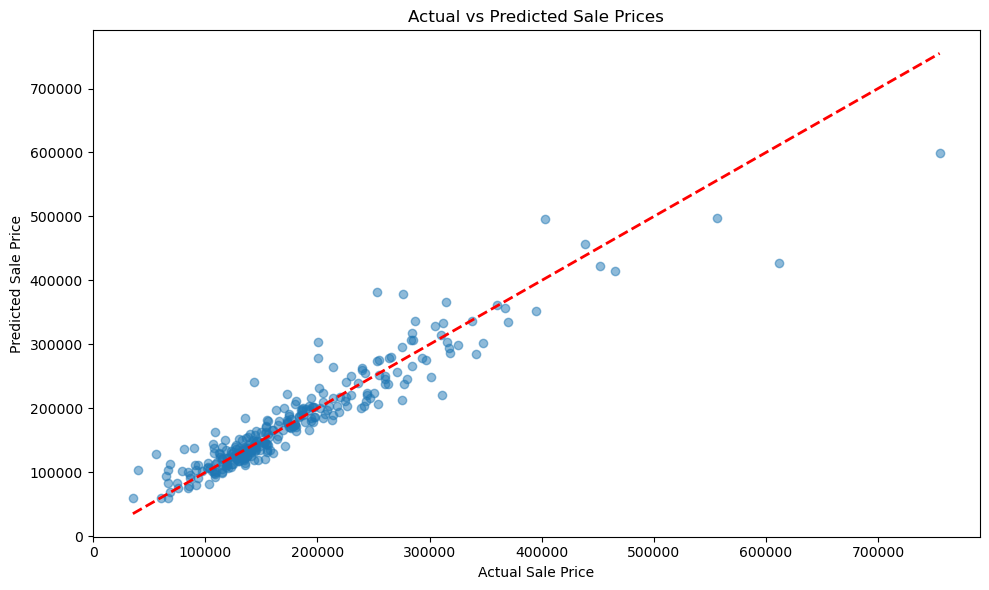

In [45]:
# Feature importance plot using the best model

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices')
plt.tight_layout()
plt.show()